In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [10]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "LCLid"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()



## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1, dropnan=True, nskip = 0):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    if n_in + n_out == 0:
        return
    # skipped sequences (t + nskip, ... t + n)
    if nskip != 0:
        for j in range(n_vars):
            for i in np.arange(0, n_out, nskip):
                cols.append(df.iloc[:,j].shift(-i))
                names += [('{}{}(t+{})'.format(df.columns[0], j+1, i))]
    # regular sequences
    else:
        # input sequence (t-n, ... t-1)
        for j in range(n_vars):
            for i in range(n_in, 0, -1):
                cols.append(df.iloc[:,j].shift(i))
                names.append('{}{}(t-{})'.format(df.columns[0], j+1, i))

        # forecast sequence (t+1, ... t+n)
        for j in range(n_vars):
            for i in range(0, n_out):
                cols.append(df.iloc[:,j].shift(-i))
                names += [('{}{}(t+{})'.format(df.columns[0], j+1, i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}".format(name), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))
    
## feature/ target construction fucntion with lag variable
def feature_target_construct(df, load_lag, target_ahead, temp_ahead, tskip = 0, wd_on = False):
    tempcols = ['temperature']
    load = df['energy']
    f_temp = pd.DataFrame()
    
    ## temp ahead series
    for col in tempcols:
        if(tskip != 0):
            temp = lag_ahead_series(df[col], 
                                 n_in = 0,
                                 n_out = temp_ahead,
                                 n_vars = 1,
                                 dropnan = True,
                                 nskip= tskip)
        else:
             temp = lag_ahead_series(df[col], 
                                 n_in = 0,
                                 n_out = temp_ahead,
                                 n_vars = 1,
                                 dropnan = True)
        f_temp = pd.concat([f_temp, temp], axis = 1)            
        
    ## load lag series
    f_load = lag_ahead_series(load,
                          n_in = load_lag,
                          n_out = 0,
                          n_vars = 1,
                          dropnan = True)
    # when f_temp exist
    if f_temp.shape[1] > 0:
        f_load, f_temp = f_load.align(f_temp, 'inner', axis = 0)
        f = pd.concat([f_temp, f_load], axis = 1)
    # when no f_temp
    else:
        f = f_load
        
    ## weekday on
    if wd_on:
        # weekday one hot encoding
        weekday = pd.get_dummies(df.iloc[:,-1])
        # alignment
        weekday , f = weekday.align(f, 'inner', axis = 0)
        f = pd.concat([weekday, f], axis = 1)
        
    ## number of LCLid on                  
    if('LCLid' in df.columns):
        nlclid = df['LCLid']
        # alignment
        nlclid, f = nlclid.align(f, 'inner', axis = 0)       
        f = pd.concat([f, nlclid], axis = 1)
        
        
    ## target part
    t = lag_ahead_series(load,
                          n_in = 0,
                          n_out = target_ahead,
                          n_vars = 1,
                          dropnan = True)
    # alignment of feature and target
    f, t = f.align(t, 'inner', axis = 0)
    
    return f, t

In [4]:
train = pd.read_csv("../data/train_nocat_hh.csv", index_col = 'tstp')
test = pd.read_csv("../data/test_nocat_hh.csv", index_col = 'tstp')

In [5]:
train

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy,LCLid,wd
tstp,,,,,,,,,,,
2011-11-23 09:00:00,4.390,229.0,4.840,4.680,1027.290,3.420,1.780,0.990,0.569000,2,2
2011-11-23 09:30:00,5.315,231.0,5.290,5.070,1027.480,3.830,1.885,0.985,0.561000,2,2
2011-11-23 10:00:00,6.240,233.0,5.740,5.460,1027.670,4.240,1.990,0.980,0.920000,6,2
2011-11-23 10:30:00,8.220,233.0,6.705,5.600,1027.615,5.090,2.325,0.930,0.588000,6,2
2011-11-23 11:00:00,10.200,233.0,7.670,5.740,1027.560,5.940,2.660,0.880,0.772000,7,2
...,...,...,...,...,...,...,...,...,...,...,...
2013-11-23 21:30:00,12.340,351.0,6.235,2.995,1026.500,3.865,3.190,0.800,1639.868001,5123,5
2013-11-23 22:00:00,12.340,350.0,6.260,2.810,1026.600,3.980,3.070,0.790,1556.448999,5123,5
2013-11-23 22:30:00,12.155,349.5,6.240,2.835,1026.655,3.880,3.170,0.790,1472.493000,5123,5


### Seeking outliers

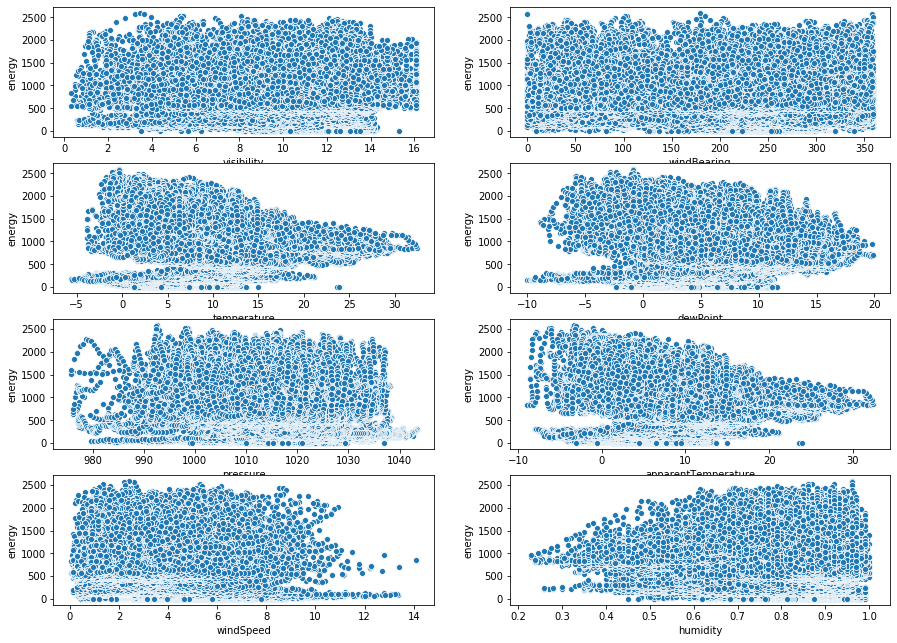

In [10]:
scatter_plot(train)

### Calibration of distribution

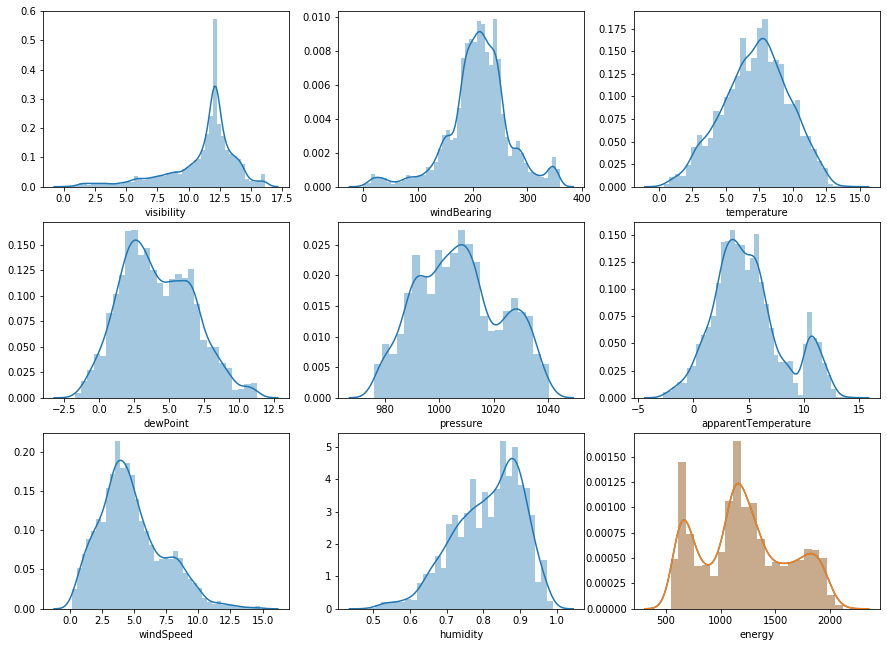

In [11]:
distri_plot(test)


We can observe that 
- left skew: **visibility**, **humidty** 
- right skew:  **windSpeed**, **temperature**
- weird shape: **windBearing**, **dewPoint**, **apparetTemp**

Apply transformation on them for more normal distribution

Index(['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'],
      dtype='object')

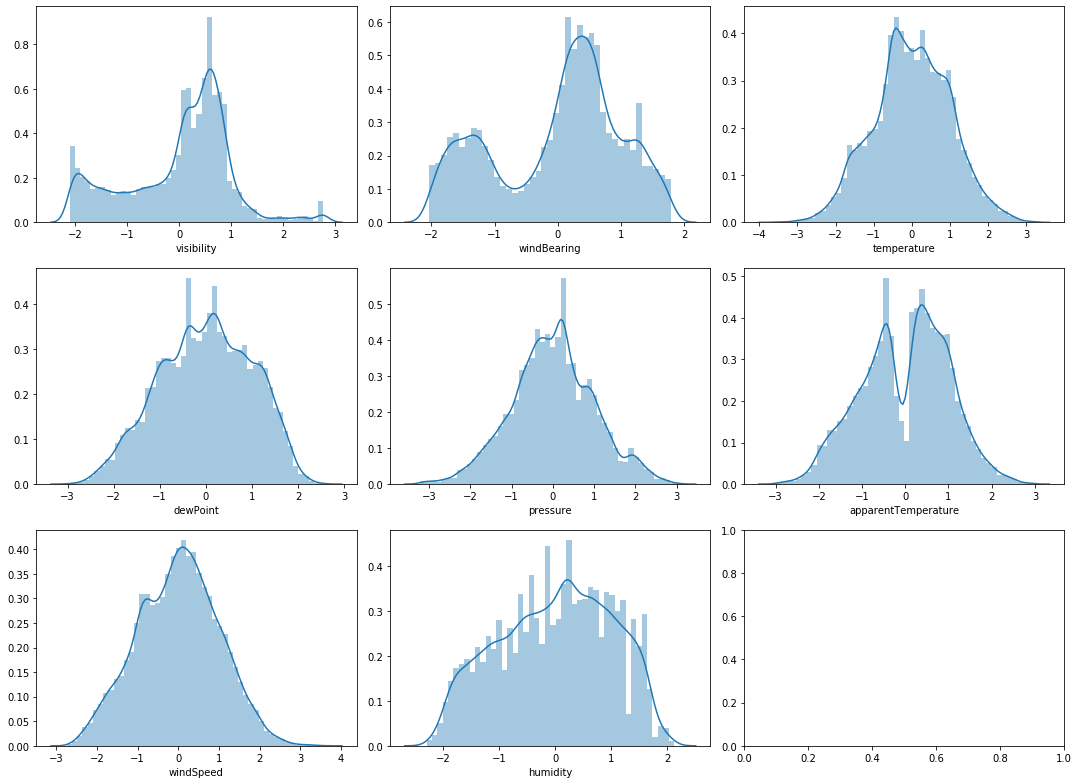

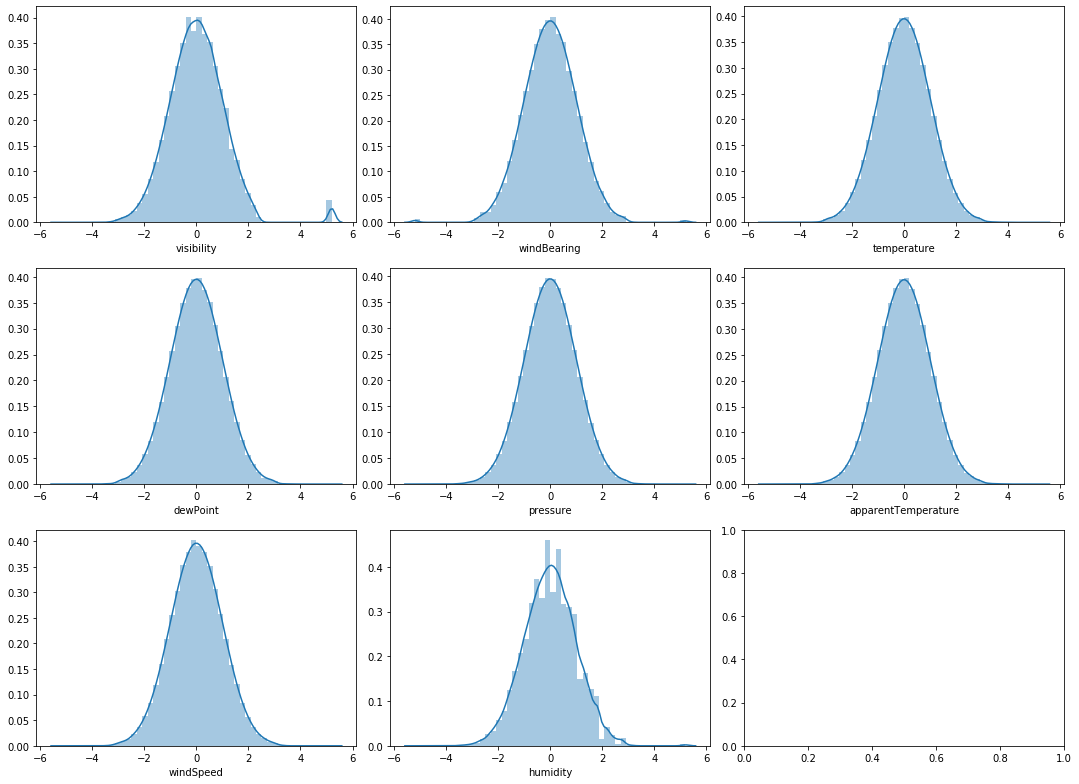

In [23]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer 
    
def power_trans(df):
    pt = PowerTransformer(method = "yeo-johnson")
    df_slice = df.iloc[:,:8]
    pt.fit(X = df_slice)
    df_trans = pd.DataFrame(pt.transform(df_slice), columns=train.columns[:8])
    return df_trans

train_trans = power_trans(train)

def quantile_trans(df):
    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
    df_slice = df.iloc[:,:8]
    qt.fit(df_slice)
    df_trans = pd.DataFrame(qt.transform(df_slice), columns=train.columns[:8])
    return df_trans

train_trans = power_trans(train)
train_quantile = quantile_trans(train)

##plot distribution
distri_plot(train_trans)
distri_plot(train_quantile)

### Creat lag ahead scenarios

In [24]:
ftrain, ttrain = feature_target_construct(train, 48, 48, 48, 3, wd_on = True)
ftest, ttest = feature_target_construct(test, 48, 48, 48, 3, wd_on = True)

### Scaling 

In [27]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(ftrain)
mt = mmscaler.transform(ftrain)


### Feature Selection

In [28]:
# Tree based feature selection
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
reg = ExtraTreeRegressor(criterion='mse', 
                         max_depth=None, min_samples_split=10, 
                         min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                         max_features='auto', max_leaf_nodes=None, 
                         min_impurity_decrease=0.0, min_impurity_split=None, 
                         random_state=31, 
                         ccp_alpha=0.0).fit(mt, ttrain)
model = SelectFromModel(reg, prefit=True)
cols = model.get_support(indices=True)
mt_feature = model.transform(mt)
cols ## the selected features column

array([35, 41, 44, 50, 54, 60, 63, 65, 69, 71])

### Gradient Boosting Regression

In [55]:
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
# lower bond
gbr_lb = GradientBoostingRegressor(loss='quantile', learning_rate=0.1, 
                                n_estimators=100, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None, 
                                random_state=None, max_features=None, 
                                alpha=0.95, verbose=0, 
                                max_leaf_nodes=None, warm_start=False, 
                                presort='deprecated', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001, 
                                ccp_alpha=0.0)
mlr_lb = RegressorChain(gbr_lb)
# upper bond
gbr_ub = GradientBoostingRegressor(loss='quantile', learning_rate=0.1, 
                                n_estimators=100, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None, 
                                random_state=None, max_features=None, 
                                alpha=0.05, verbose=0, 
                                max_leaf_nodes=None, warm_start=False, 
                                presort='deprecated', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001, 
                                ccp_alpha=0.0)
mlr_ub = RegressorChain(gbr_ub)
# prediction
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, 
                                n_estimators=100, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None, 
                                random_state=None, max_features=None, 
                                verbose=0, 
                                max_leaf_nodes=None, warm_start=False, 
                                presort='deprecated', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001, 
                                ccp_alpha=0.0)
mlr = RegressorChain(gbr)


In [57]:
from sklearn.model_selection import train_test_split
X = mt_feature
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

%time mlr.fit(train_X, train_y)
%time mlr_lb.fit(train_X, train_y)
%time mlr_ub.fit(train_X, train_y)

CPU times: user 17min 46s, sys: 3.34 s, total: 17min 49s
Wall time: 17min 57s
CPU times: user 18min 15s, sys: 4.5 s, total: 18min 20s
Wall time: 18min 30s
CPU times: user 17min 34s, sys: 1.1 s, total: 17min 36s
Wall time: 17min 36s


RegressorChain(base_estimator=GradientBoostingRegressor(alpha=0.05,
                                                        ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='quantile',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                          

### Validation set

In [58]:
ypred_lb = mlr_lb.predict(val_X[:5,:])
ypred_ub = mlr_ub.predict(val_X[:5,:])
ypred = mlr.predict(val_X[:5,:])

**Metrics**

In [59]:
o_y = np.transpose(val_y.iloc[:1,:].to_numpy())
p_y = np.transpose(ypred[:1,:])
get_eval(o_y, p_y)

MSE: 1341.8432854692894
MAE: 29.928978263005888
r2_score: 0.9708283016361321


**Visualization**

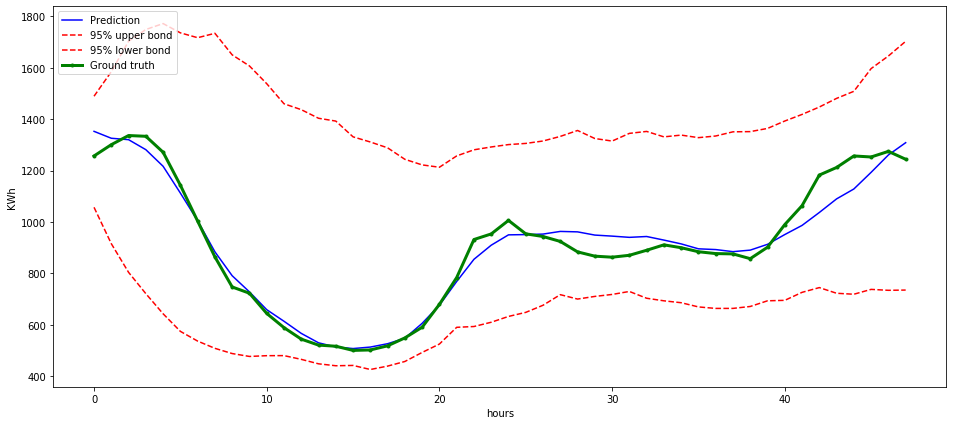

In [60]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred[3:4,:].reshape(-1,1), 'b-',label='Prediction')
plt.plot(ypred_ub[3:4,:].reshape(-1,1), 'r--', label='95% upper bond')
plt.plot(ypred_lb[3:4,:].reshape(-1,1), 'r--', label='95% lower bond')
plt.plot(val_y.iloc[3:4,:].to_numpy().reshape(-1,1), 'g.-', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()

### Testing set

In [61]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ftest)

## feature pick up
test_x = mtest[:,cols]
test_y = ttest

In [62]:
ypred_t_lb = mlr_lb.predict(test_x[:5,:])
ypred_t_ub = mlr_ub.predict(test_x[:5,:])
ypred_t = mlr.predict(test_x[:5,:])

**Metrics**

In [66]:
o_yt = np.transpose(test_y.iloc[:1,:].to_numpy())
p_yt = np.transpose(ypred_t[:1,:])
get_eval(o_yt, p_yt)

MSE: 38068.07368198173
MAE: 149.95717774608428
r2_score: 0.7788963077549684


**Visualization**


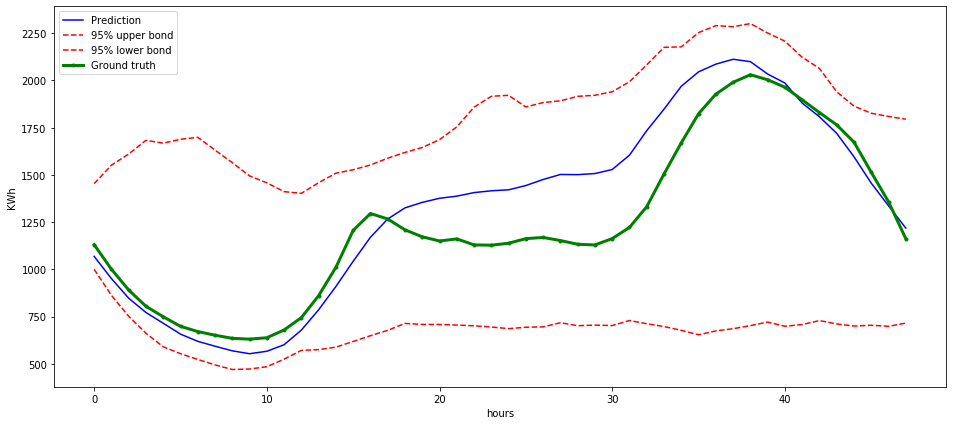

In [64]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred_t[0:1,:].reshape(-1,1), 'b-',label='Prediction')
plt.plot(ypred_t_ub[0:1,:].reshape(-1,1), 'r--', label='95% upper bond')
plt.plot(ypred_t_lb[0:1,:].reshape(-1,1), 'r--', label='95% lower bond')
plt.plot(test_y.iloc[0:1,:].to_numpy().reshape(-1,1), 'g.-', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()



### Random Forest Regression: Manual ML

In [43]:
from sklearn.ensemble import RandomForestRegressor

X = mt_feature
y = ttrain

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

rfr = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
rfr.fit(train_X, train_y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [44]:
yhat = rfr.predict(val_X)

### Result evaluation: validation set

**Metrics**


In [45]:
get_eval(val_y, yhat)

MSE: 9243.807641258862
MAE: 44.6349336884169
r2_score: 0.9658536574842163


**Visualization**

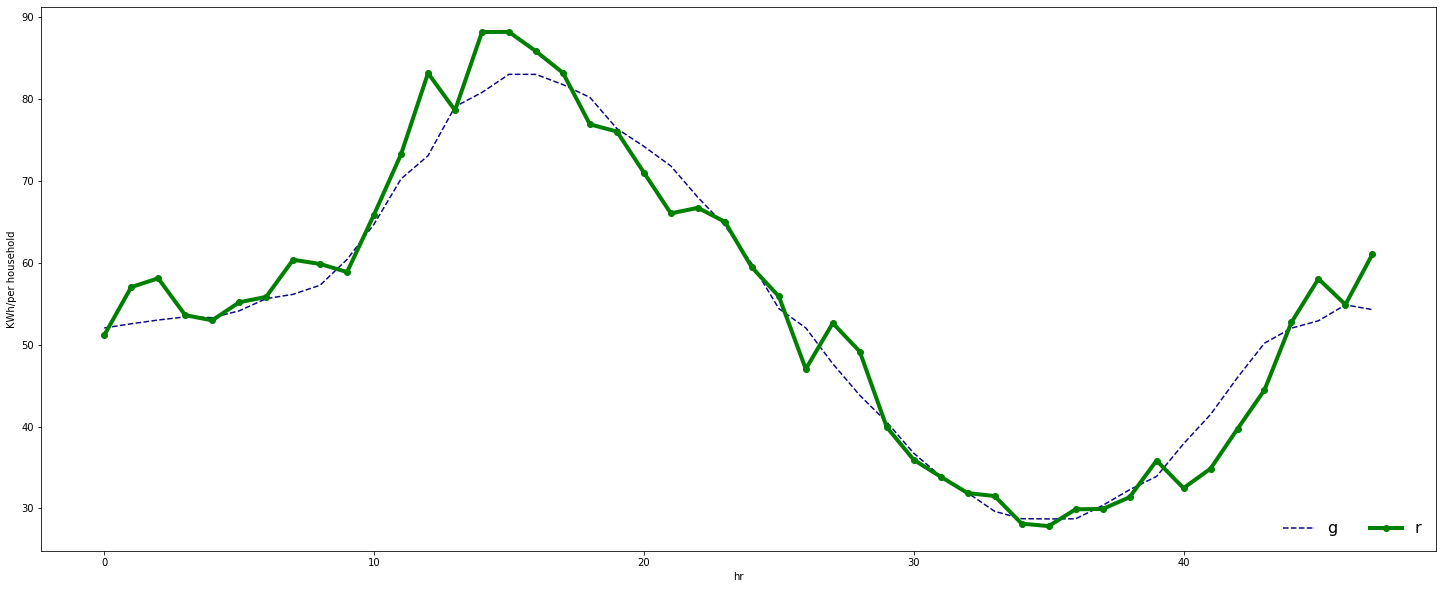

In [47]:
## assignment
real = val_y.to_numpy()
guess = yhat
real = real[:1,:49]
guess = guess[:1,:49]
rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Result evaluation: test set

**Data preparation for test set**

- prepare recency features
- feature scaling 
- identify feature picked from previous training process

In [48]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ftest)

## feature pick up
test_x = mtest[:,cols]
test_y = ttest

In [49]:
## Prediction with test data
yt_hat = rfr.predict(test_x)

**Performance**

In [50]:
get_eval(test_y, yt_hat)

MSE: 9130.16995446546
MAE: 67.3711356024553
r2_score: 0.9425749040296214


**Visualization**

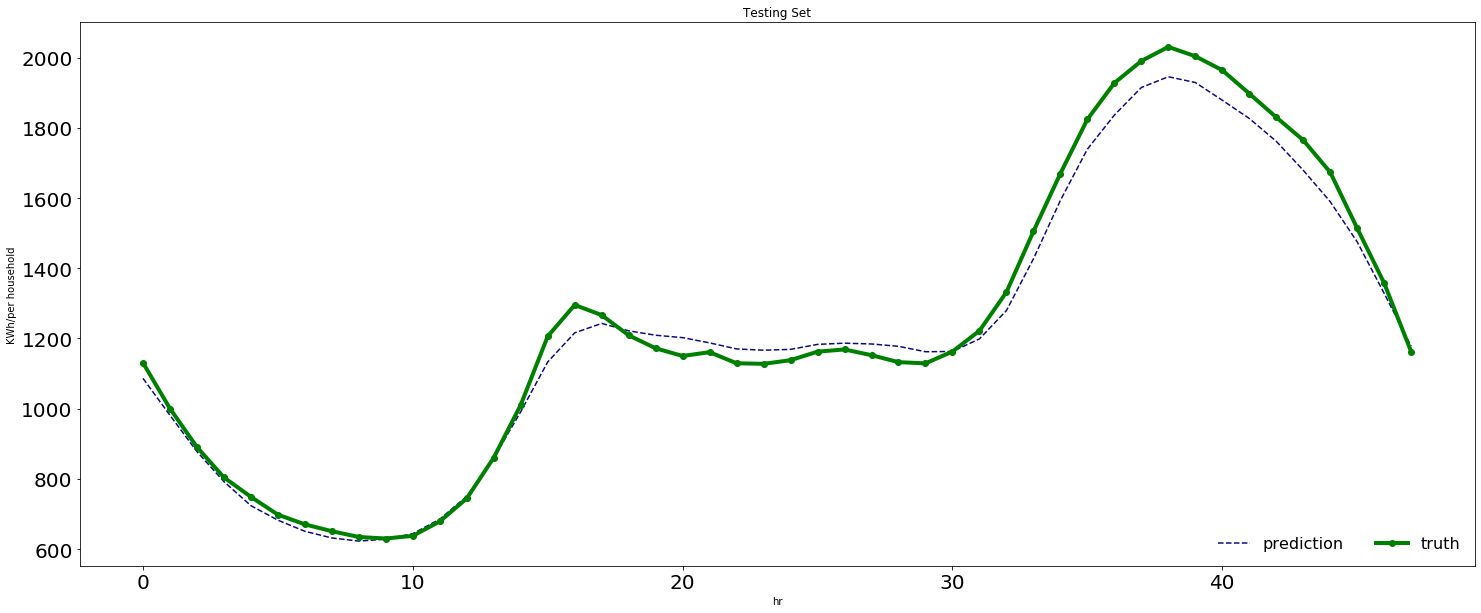

In [52]:
real = test_y.to_numpy()
guess = yt_hat
real = real[0:1,:49]
guess = guess[0:1,:49]
rpdf = plot_df(real,"truth")
gpdf = plot_df(guess,"prediction")
    
#plot 
ax = plt.gca()
ax.title.set_size(20)

gpdf.plot(title = "Testing Set", figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax,fontsize= 20)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Xgboost: Manual

In [69]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

X = mt_feature
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

xgbr = xgb.XGBRegressor(max_depth=10, njobs= 4)
mr = MultiOutputRegressor(xgbr, n_jobs = 4)
mr.fit(train_X, train_y)
#rc = MultiOutputRegressor(xgbr, cv = 5, random_state = 123)
#rc.fit(train_X, train_y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=10, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, njobs=4, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                        

### Result evaluation: test set

In [70]:
yhat = mr.predict(val_X)

In [71]:
get_eval(val_y, yhat)

MSE: 8701.974670774494
MAE: 41.92344895841223
r2_score: 0.968097446558185


**Visualization**

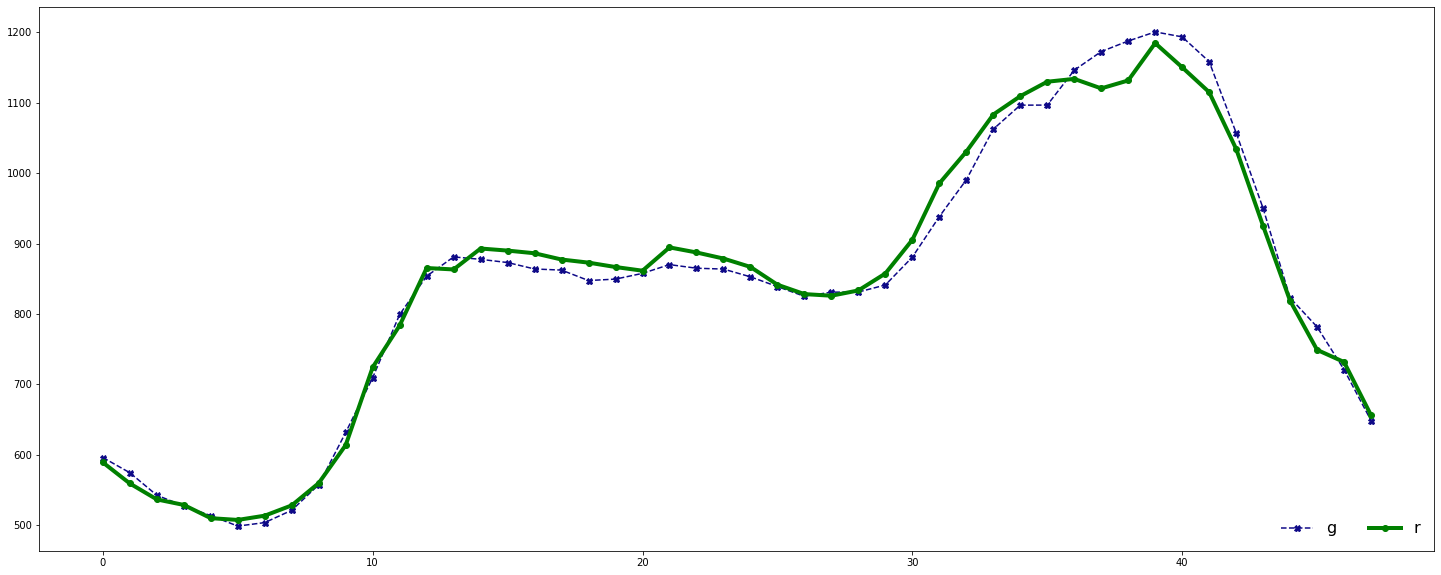

In [72]:
real = val_y.to_numpy()
guess = yhat
real = real[90:91,:49]
guess = guess[90:91,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Result evaluation: test set

In [73]:
yhat = mr.predict(test_x)

In [74]:
get_eval(test_y, yhat)

MSE: 8696.64343368761
MAE: 65.57019182195485
r2_score: 0.9453016114387421


**Visualization**


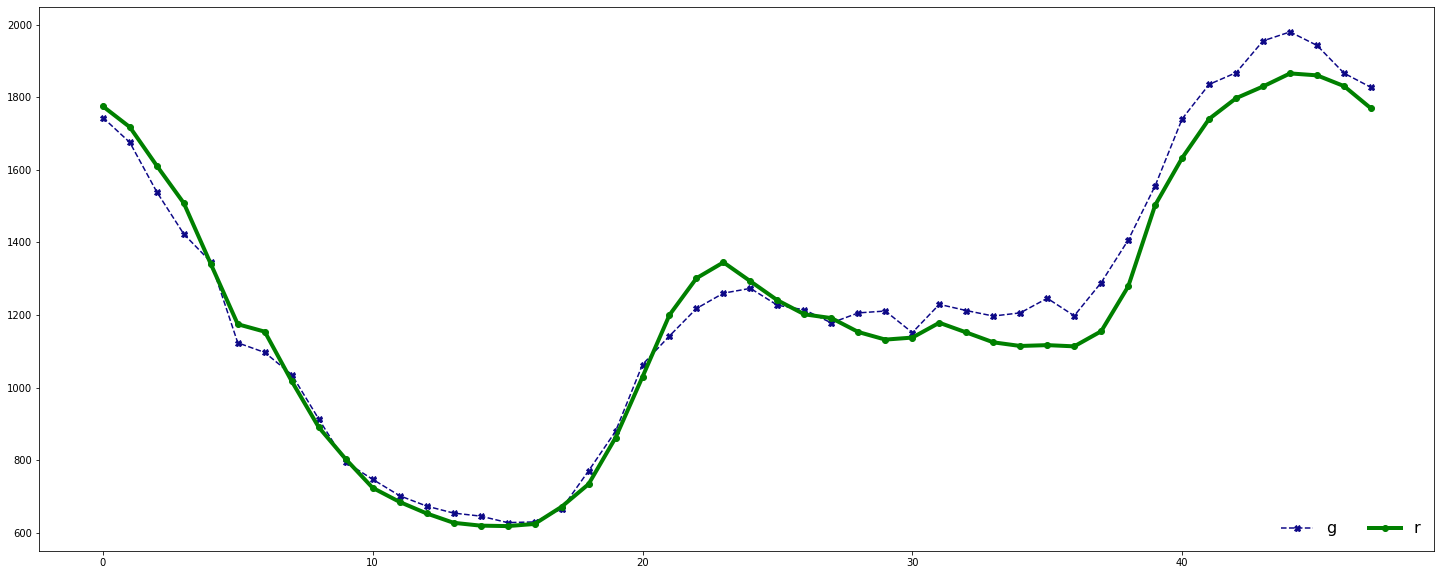

In [76]:
real = test_y.to_numpy()
guess = yhat
real = real[90:91,:49]
guess = guess[90:91,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### LSTM

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 50)             12200     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 48)             2448      
Total params: 14,648
Trainable params: 14,648
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 3s - loss: 936419.2775
Epoch 2/50
 - 2s - loss: 718738.4551
Epoch 3/50
 - 2s - loss: 422948.9276
Epoch 4/50
 - 2s - loss: 207642.2880
Epoch 5/50
 - 2s - loss: 117759.7985
Epoch 6/50
 - 2s - loss: 97117.4094
Epoch 7/50
 - 2s - loss: 93855.1727
Epoch 8/50
 - 2s - loss: 92526.3343
Epoch 9/50
 - 2s - loss: 90976.0225
Epoch 10/50
 - 2s - loss: 89096.3271
Epoch 11/50
 - 2s - loss: 86887.2654
Epoch 12/50
 - 2s - loss: 84420.3519
Epoch 13/50
 - 2s - loss: 81827.7998
Epoch 14/50
 - 2s - loss: 79030.188

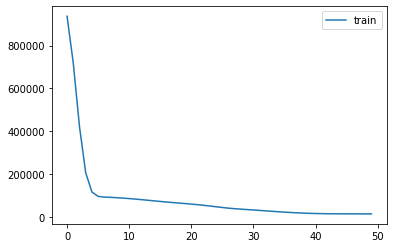

In [93]:
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

train_X, val_X, train_y, val_y = train_test_split(mt_feature, ttrain, train_size = 0.7, test_size = 0.3)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.to_numpy().reshape((train_y.shape[0],1, train_y.shape[1]))

# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(48)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

### Validation sets

**Metrics**


In [105]:
yhat = model.predict(val_X.reshape(val_X.shape[0], 1, val_X.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

In [113]:
get_eval(val_y.iloc[:1,:].to_numpy().reshape(-1,1), yhat[:1,:].reshape(-1,1))

MSE: 13269.750050022956
MAE: 95.93651328863933
r2_score: 0.8499806715303087


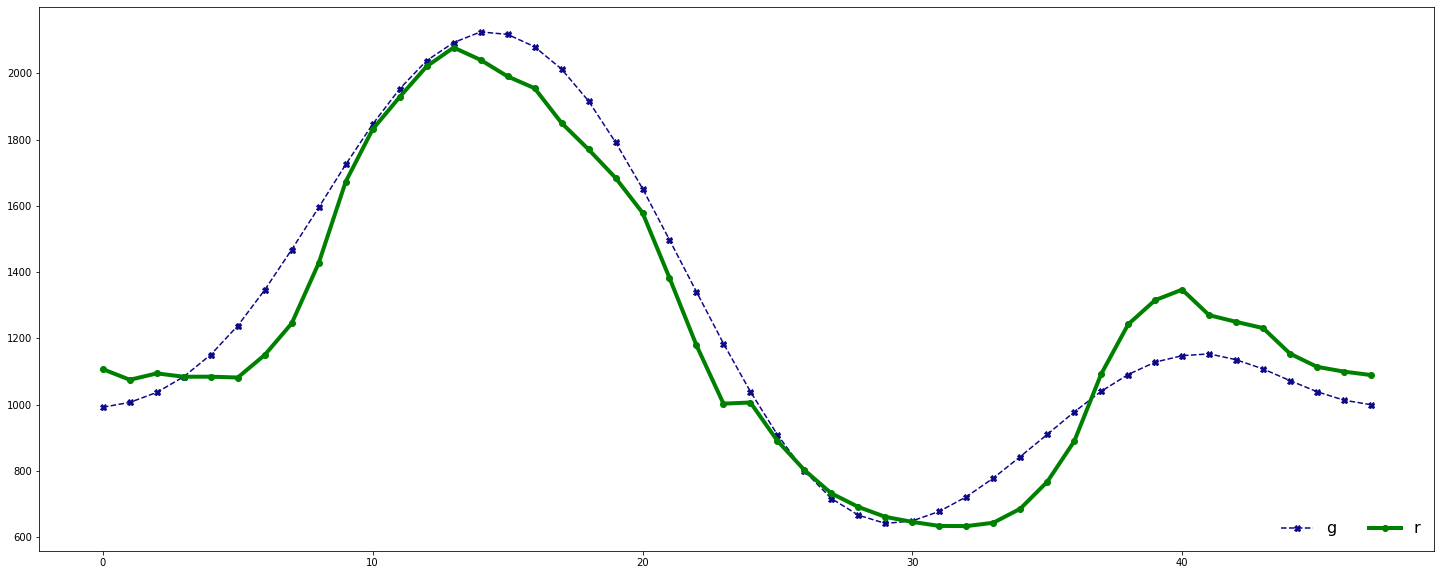

In [114]:
real = val_y.to_numpy()
guess = yhat
real = real[10:11,:49]
guess = guess[10:11,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Testing sets

In [118]:
yhat = model.predict(test_x.reshape(test_x.shape[0], 1, test_x.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

**Metrics**

In [122]:
get_eval(test_y.iloc[:1,:].to_numpy().reshape(-1,1), yhat[:1,:].reshape(-1,1))

MSE: 32139.836515522577
MAE: 143.73771954529622
r2_score: 0.8133281820062981


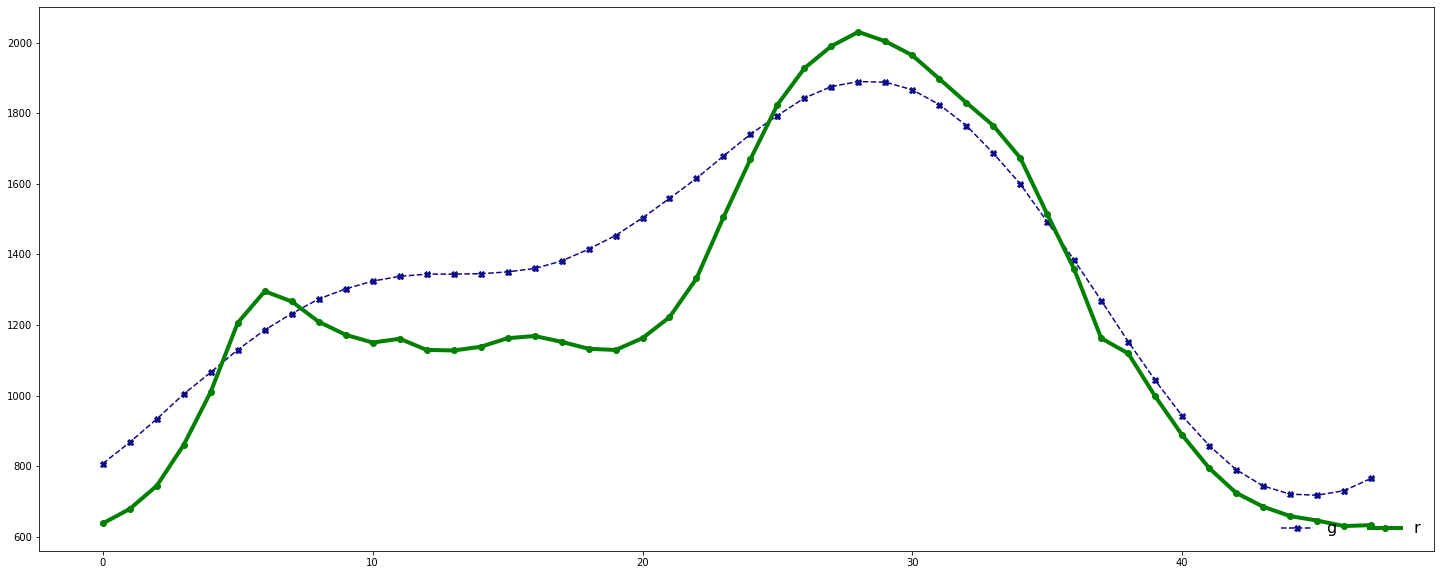

In [123]:
real = test_y.to_numpy()
guess = yhat
real = real[10:11,:49]
guess = guess[10:11,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()